In [0]:
from fastai.collab import *
from fastai.tabular import *

# Загрузка данных

In [0]:
movies = pd.read_csv('movies.csv',encoding='latin-1')
users = pd.read_csv('users.csv',encoding='latin-1')
ratings = pd.read_csv('ratings.csv',encoding='latin-1')

In [0]:
display(movies.sample(2))
display(users.sample(2))
display(ratings.sample(2))

,movie_id,movie,genres
2032,2101,Squanto: A Warrior's Tale (1994),Adventure|Drama
872,884,Sweet Nothing (1995),Drama


,user_id,gender,age,occupation,zip_code
2989,2990,M,35-44,programmer,45243
4040,4041,M,18-24,clerical/admin,48005


,user_id,movie_id,rating,timestamp
426498,2590,1347,5,973839904
507657,3125,2289,4,993073797


In [0]:
ratings.rating.value_counts()/len(ratings)*100

4    34.889808
3    26.114242
5    22.626271
2    10.753453
1     5.616226
Name: rating, dtype: float64

In [0]:
df = pd.merge(ratings, movies, on='movie_id', how='left')
df.isna().sum(), len(df), len(ratings)

(user_id      0
 movie_id     0
 rating       0
 timestamp    0
 movie        0
 genres       0
 dtype: int64, 1000209, 1000209)

In [0]:
df = pd.merge(df, users, on='user_id', how='left')
df.isna().sum(), len(df), len(ratings)

(user_id       0
 movie_id      0
 rating        0
 timestamp     0
 movie         0
 genres        0
 gender        0
 age           0
 occupation    0
 zip_code      0
 dtype: int64, 1000209, 1000209)

In [0]:
df.drop(['timestamp','movie'],axis=1, inplace =True)
df.head(2)

,user_id,movie_id,rating,genres,gender,age,occupation,zip_code
0,1,1193,5,Drama,F,Under 18,K-12 student,48067
1,1,661,3,Animation|Children's|Musical,F,Under 18,K-12 student,48067


# Создание модели

In [0]:
class EmbeddingNNwithCont(TabularModel):
    "Subclass `TabularModel` to create a NN suitable for collaborative filtering."
    def __init__(self, emb_szs:ListSizes, layers:Collection[int]=None, ps:Collection[float]=None, n_cont:int = 0,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False):
      
        super().__init__(emb_szs=emb_szs, n_cont=n_cont, out_sz=1, layers=layers, ps=ps, emb_drop=emb_drop, y_range=y_range,
                         use_bn=use_bn, bn_final=bn_final)

    def forward(self, x_cat:Tensor, x_cont:Tensor = None) -> Tensor:
        return super().forward(x_cat, x_cont)
      
        
        
def experimental_collab_learner(data:DataBunch, layers:Collection[int], emb_szs:Dict[str,int]=None, 
                    ps:Collection[float]=None, emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True,
                    bn_final:bool=False, metrics=None, **learn_kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `TabularModel` created using the remaining params."
    emb_szs = data.get_emb_szs(ifnone(emb_szs, {}))
    model = EmbeddingNNwithCont(emb_szs=emb_szs, n_cont = len(data.cont_names), layers=layers, ps=ps, emb_drop=emb_drop,
                         y_range=y_range, use_bn=use_bn, bn_final=bn_final)
    return Learner(data, model, metrics=metrics, **learn_kwargs)

In [0]:
OptTabTfms = Optional[Collection[TabularProc]]
class CollabTabularDataBunch(DataBunch):
    "Create a `DataBunch` suitable for tabular data."
    @classmethod
    def from_df(cls, df:DataFrame, rating_name:str, valid_pct:int=0.2, seed:int=None, procs:OptTabTfms=None,
                cat_names:OptStrList=None, cont_names:OptStrList=None, classes:Collection=None, path:PathOrStr='.',
                test_df=None, bs:int=64, val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None, 
                device:torch.device=None, collate_fn:Callable=data_collate, no_check:bool=False)->DataBunch:
        "Create a `DataBunch` from `df` and `valid_pct` with `dep_var`. `kwargs` are passed to `DataBunch.create`."
        
        cat_names = ifnone(cat_names, []).copy()
        cont_names = ifnone(cont_names, list(set(df)-set(cat_names)-{dep_var}))
        procs = listify(procs)
        src = (TabularList.from_df(df,path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(valid_pct=valid_pct, seed=seed).label_from_df(cols=rating_name))
        OptTabTfms
        #Раскомментить и переписать если будем клссифицировать зависимую переменную
        #src = src.label_from_df(cols=dep_var) if classes is None else src.label_from_df(cols=dep_var, classes=classes)
        
        if test_df is not None: src.add_test(TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names,
                                                                 processor = src.train.x.processor))
        return src.databunch(path=path, bs=bs, val_bs=val_bs, num_workers=num_workers, device=device, 
                             collate_fn=collate_fn, no_check=no_check)

# Сравнение моделей

In [0]:
cat_names = ['user_id', 'movie_id']#, 'occupation', 'genres', 'gender',  'age', 'zip_code']
dep_var = 'rating'

procs = [FillMissing, Categorify, Normalize]
data = CollabTabularDataBunch.from_df(df[['user_id', 'movie_id','rating']], dep_var, procs=procs, seed = 42, bs=512, device='cuda', cat_names=cat_names)

In [0]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

In [0]:
emb_szs={'user_id': 50,'movie_id': 50, 'occupation':10, 'genres':150, 'gender':5,  'age':10, 'zip_code':200}
learn = experimental_collab_learner(data, layers=[50,20], y_range=(0.,5.), loss_func=MSELossFlat, metrics=accuracy)

### EmbDotBias (*Простая факторизация*)

In [0]:
data = CollabDataBunch.from_df(ratings, user_name='user_id', item_name='movie_id',rating_name='rating', seed = 42, bs=512, device='cuda')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


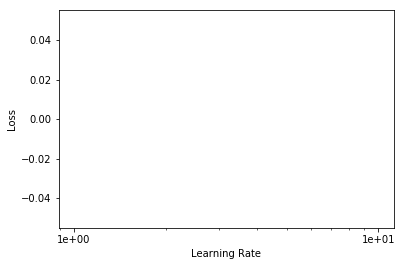

In [0]:
learn = collab_learner(data, n_factors=150, y_range=(0.,5.), metrics = mse, loss_func =exp_rmspe, callback_fns=ShowGraph)
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,mean_squared_error,time


KeyboardInterrupt: ignored

### EmbeddingNN

In [0]:
data = CollabDataBunch.from_df(ratings, user_name='user_id', item_name='movie_id',rating_name='rating', seed = 42, bs=512, device='cuda')

In [0]:
learn = collab_learner(data, layers=[50,20], use_nn=True, emb_szs={'user_id': 150,'movie_id': 150}, y_range=(0.,5.))
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.858028,0.853122,00:40
1,0.798472,0.801732,00:40
2,0.754413,0.780997,00:39
3,0.732717,0.772082,00:43
4,0.697198,0.775745,00:42


### Копия EmbeddingNN

In [0]:
procs = [FillMissing, Categorify, Normalize]
valid_idx = df.sample(frac=0.2).index.tolist()
cat_names = ['user_id', 'movie_id']#, 'occupation', 'genres', 'gender',  'age', 'zip_code']
cont_names = None
#cont_names = ifnone(cont_names, list(set(df)-set(cat_names)-{dep_var}))

dep_var = 'rating'
emb_szs={'user_id': 50,'movie_id': 50, 'occupation':10, 'genres':150, 'gender':5,  'age':10, 'zip_code':200}

data = (TabularList.from_df(path='.', df=df[['user_id', 'movie_id','rating']], procs=procs, cat_names=cat_names, cont_names=cont_names)
                        .split_by_idx(valid_idx)
                        .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
                        .databunch(bs=512, device='cuda'))


learn = tabular_learner(data, layers=[50,20], emb_szs=emb_szs, loss_func = exp_rmspe)

In [0]:
learn.fit_one_cycle(8, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.786564,0.783801,00:37


KeyboardInterrupt: ignored

### EmbeddingNN с фичами

In [0]:
procs = [FillMissing, Categorify, Normalize]
valid_idx = df.sample(frac=0.2).index.tolist()
cat_names = ['user_id', 'movie_id', 'occupation', 'genres', 'gender',  'age', 'zip_code']
cont_names = None
#cont_names = ifnone(cont_names, list(set(df)-set(cat_names)-{dep_var}))

dep_var = 'rating'
emb_szs={'user_id': 50,'movie_id': 50, 'occupation':10, 'genres':150, 'gender':5,  'age':10, 'zip_code':200}

data = (TabularList.from_df(path='.', df=df, procs=procs, cat_names=cat_names, cont_names=cont_names)
                        .split_by_idx(valid_idx)
                        .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
                        .databunch(bs=512, device='cuda'))


learn = tabular_learner(data, layers=[50,20], emb_szs=emb_szs,y_range=(0.,5.))

In [0]:
learn.fit_one_cycle(8, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.852729,0.840173,01:02
1,0.810055,0.796651,01:02
2,0.760647,0.767397,01:01
3,0.731196,0.752372,01:04
4,0.697299,0.746131,01:01
5,0.674319,0.737101,01:04
6,0.641688,0.741636,01:01
7,0.606667,0.748461,01:03


# Дополнительное вытягивание фич

In [0]:
display(movies.sample(10))

,movie_id,movie,genres
82,83,Once Upon a Time... When We Were Colored (1995),Drama
2635,2704,"Lovers on the Bridge, The (Les Amants du Pont-...",Drama|Romance
1087,1103,Rebel Without a Cause (1955),Drama
212,214,Before the Rain (Pred dozhdot) (1994),Drama
2254,2323,"Cruise, The (1998)",Documentary
2632,2701,Wild Wild West (1999),Action|Sci-Fi|Western
3617,3686,Flatliners (1990),Thriller
826,837,Matilda (1996),Children's|Comedy
1479,1514,Temptress Moon (Feng Yue) (1996),Romance
1923,1992,Child's Play 2 (1990),Horror


In [0]:
movies.movie.str[-1].unique()

array([')'], dtype=object)

In [0]:
movies.movie.str.extract(r"\(([^)]+)\)$").unique()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


array(['1995', '1994', '1996', '1976', ..., '1919', '2000', '1920', '1921'], dtype=object)

In [0]:
max_jen = 0
for a in movies.genres.unique():
  if len(a.split('|'))>max_jen:
    max_jen=len(a.split('|'))
    save_jen = a
    
save_jen, max_jen

("Action|Animation|Children's|Sci-Fi|Thriller|War", 6)

In [0]:
genres = set('|'.join(movies.genres.unique()).split('|'))

In [0]:
df2 = movies

for genre in genres:
  df2[genre]=movies['genres'].str.contains(genre)

In [0]:
df2['date'] = movies.movie.str.extract(r"\(([^)]+)\)$").astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [0]:
display(df2.head(3))

,movie_id,movie,genres,Fantasy,Western,Action,Documentary,Adventure,Comedy,Thriller,...,Romance,Crime,Children's,Sci-Fi,Drama,Animation,War,Mystery,Horror,date
0,1,Toy Story (1995),Animation|Children's|Comedy,False,False,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,1995


In [0]:
df3 = ratings

In [0]:
df3.timestamp = pd.to_datetime(ratings.timestamp, unit='s').dt.year

In [0]:
df_new = pd.merge(df3, users, on='user_id', how='left')

In [0]:
df_new = pd.merge(df_new, df2, on='movie_id', how='left')

In [0]:
set(df_new)

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'age',
 'date',
 'gender',
 'genres',
 'movie',
 'movie_id',
 'occupation',
 'rating',
 'timestamp',
 'user_id',
 'zip_code'}

### EmbeddingNN с доп фичами

In [0]:
procs = [FillMissing, Categorify, Normalize]
valid_idx = df.sample(frac=0.2).index.tolist()
cat_names = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
             'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age', 'date', 'gender',
             'genres', 'movie_id', 'occupation', 'timestamp', 'user_id', 'zip_code']
cont_names = None
#cont_names = ifnone(cont_names, list(set(df)-set(cat_names)-{dep_var}))

dep_var = 'rating'
emb_szs={'user_id': 50,'movie_id': 50, 'occupation':10, 'genres':150, 'gender':5,  'age':10, 'date':10, 'timestamp':10, 'zip_code':200}

data = (TabularList.from_df(path='.', df=df_new, procs=procs, cat_names=cat_names, cont_names=cont_names)
                        .split_by_idx(valid_idx)
                        .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
                        .databunch(bs=512, device='cuda'))


learn = tabular_learner(data, layers=[50,20], emb_szs=emb_szs,y_range=(0.,5.))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


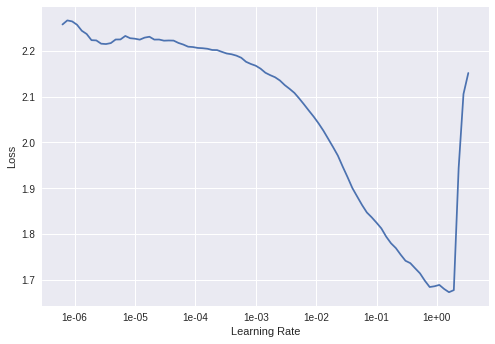

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8, 4e-2, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.855934,0.841443,01:12
1,0.818749,0.810699,01:15
2,0.775450,0.783935,01:10
3,0.764793,0.761997,01:12
4,0.733561,0.758230,01:13
5,0.700399,0.734539,01:12
6,0.660689,0.729217,01:11
7,0.628696,0.734003,01:12


### Большая EmbeddingNN с доп фичами

In [0]:
procs = [FillMissing, Categorify, Normalize]
valid_idx = df.sample(frac=0.2).index.tolist()
cat_names = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
             'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
             'date', 'gender', 'genres', 'movie_id', 'occupation', 'timestamp',
             'user_id', 'zip_code']
cont_names = None
#cont_names = ifnone(cont_names, list(set(df)-set(cat_names)-{dep_var}))

dep_var = 'rating'
emb_szs={'user_id': 50,'movie_id': 50, 'occupation':10, 'genres':150, 'gender':5,  'age':10, 'date':10, 'timestamp':10, 'zip_code':200}

data = (TabularList.from_df(path='.', df=df_new, procs=procs, cat_names=cat_names, cont_names=cont_names)
                        .split_by_idx(valid_idx)
                        .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
                        .databunch(bs=512, device='cuda'))


learn = tabular_learner(data, layers=[1000,500], emb_szs=emb_szs,y_range=(0.,5.))

In [0]:
learn.fit_one_cycle(8, 1e-2, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.840309,0.843289,01:14
1,0.785668,0.780018,01:14
2,0.747719,0.750360,01:13
3,0.715422,0.729025,01:14
4,0.669230,0.715430,01:14
5,0.633295,0.714905,01:14
6,0.584730,0.719874,01:15
7,0.544619,0.729619,01:15


### Большая EmbeddingNN  с доп фичами и дропаутом

In [0]:
procs = [FillMissing, Categorify, Normalize]
valid_idx = df.sample(frac=0.2).index.tolist()
cat_names = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
             'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
             'date', 'gender', 'genres', 'movie_id', 'occupation', 'timestamp',
             'user_id', 'zip_code']
cont_names = None
#cont_names = ifnone(cont_names, list(set(df)-set(cat_names)-{dep_var}))

dep_var = 'rating'
emb_szs={'user_id': 50,'movie_id': 50, 'occupation':10, 'genres':150, 'gender':5,  'age':10, 'date':10, 'timestamp':10, 'zip_code':200}

data = (TabularList.from_df(path='.', df=df_new, procs=procs, cat_names=cat_names, cont_names=cont_names)
                        .split_by_idx(valid_idx)
                        .label_from_df(cols=dep_var, label_cls=FloatList, log=False)
                        .databunch(bs=512, device='cuda'))


learn = tabular_learner(data, layers=[1000,500], ps=[0.25,0.1], emb_szs=emb_szs, emb_drop=0.1, y_range=(0.,5.))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


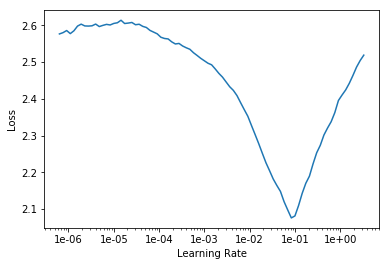

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.846403,0.828939,01:13
1,0.794433,0.786699,01:13
2,0.759835,0.758194,01:13
3,0.734304,0.736420,01:13
4,0.699769,0.727798,01:14
5,0.683589,0.716919,01:13
6,0.653958,0.710921,01:14
7,0.623605,0.713620,01:12
8,0.591783,0.717156,01:15
9,0.578981,0.720683,01:15
